In [1]:
import os 
print(os.getcwd())

C:\Users\rorym\OneDrive\Documents\Final Year\Econometrics of Financial Markets\CAPM Assignment


<h1>Import Libraries</h1>

In [2]:
#Import relevant modules
import pandas as pd
import numpy as np
import statsmodels
import scipy
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as smp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sts
from tabulate import tabulate 
from statsmodels.compat import lzip
from statsmodels.iolib.summary2 import summary_col

<h1>Gathering Data</h1>
<h2>a) & b)</h2>


In [3]:
#Read in and calculate log returns of data

#Function used for efficiency

def log_data(excel, subject : str):
    
    df = pd.read_excel(excel, index_col = "Date", parse_dates= True )
    df["log_ret_" + subject] = 100*np.log(df[subject]).diff()
    df.dropna(inplace = True)
    return df 

spx = log_data("SP500.xls", subject = "SP500")
btc = log_data("btc.xls", subject = "BTCUSD")
eth = log_data("eth.xls", subject = "ETHUSD")
fed_funds = pd.read_excel("fedfunds.xls",index_col = "Date", parse_dates = True)

In [4]:
#Merge into a master dataframe for convenience
    
master_df =  pd.merge(spx,btc, how = "left", on = "Date" )    
master_df = pd.merge(master_df,eth, how = "left", on ="Date")
master_df = pd.merge(master_df,fed_funds, how = "left", on ="Date")
master_df.dropna(inplace= True )

# Calculate excess returns
master_df["ex_ret_SP500"] =  master_df["log_ret_SP500"] - master_df["EFFR"]

for coin in ["BTCUSD", "ETHUSD"]:
    
    master_df["ex_ret_" + coin] = master_df["log_ret_"+ coin] - master_df["EFFR"]


In [5]:
master_df.head()

,SP500,log_ret_SP500,BTCUSD,log_ret_BTCUSD,ETHUSD,log_ret_ETHUSD,EFFR,ex_ret_SP500,ex_ret_BTCUSD,ex_ret_ETHUSD
Date,,,,,,,,,,
2016-06-05,2100.170,0.928508,551.332857,15.087224,13.852857,11.079503,0.350,0.578508,14.737224,10.729503
2016-06-12,2110.442,0.487911,599.260000,8.335684,14.525714,4.742897,0.370,0.117911,7.965684,4.372897
2016-06-19,2075.018,-1.692758,734.215714,20.310731,16.532857,12.942926,0.374,-2.066758,19.936731,12.568926
2016-06-26,2081.666,0.319871,655.518571,-11.337624,13.661429,-19.077331,0.386,-0.066129,-11.723624,-19.463331
2016-07-03,2061.842,-0.956878,666.557143,1.669924,12.572857,-8.303613,0.388,-1.344878,1.281924,-8.691613


<h2>c)</h2>

In [6]:
def regression (df,crypto, constant = True, robust = False):
    
    if robust == True:
        model = smf.ols(formula = f"ex_ret_{crypto} ~ ex_ret_SP500", 
                        data = df).fit(cov_type="HAC",cov_kwds={'maxlags':12,'use_correction':True})
        print(f"Regression of {crypto} on SP500 using robust standard errors:\n", model.summary())
        return model

    if constant == True:
        model = smf.ols(formula = f"ex_ret_{crypto} ~ ex_ret_SP500", data = df).fit()

    elif constant == False: # Generalise formula to be re-used in Part G
        model =  smf.ols(formula = f"ex_ret_{crypto} ~ ex_ret_SP500 -1", data = df).fit()
    print(f"Regression of {crypto} on SP500:\n\n", model.summary(),"\n")


    return model 

btc_regress = regression(master_df, "BTCUSD")
eth_regress = regression(master_df, "ETHUSD")


Regression of BTCUSD on SP500:

                             OLS Regression Results                            
Dep. Variable:          ex_ret_BTCUSD   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     69.24
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.17e-15
Time:                        22:07:25   Log-Likelihood:                -1511.7
No. Observations:                 431   AIC:                             3027.
Df Residuals:                     429   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

In [7]:
def jarque_bera(reg, crypto):
   
    test = sms.jarque_bera(reg.resid)
    labels = ['JB Statistic', 'Chi-Squared','Skewness','Kurtosis'] 
    table = tabulate(zip(labels,test),tablefmt = "fancy_grid")
 
    print(f"Results of Jarque-Bera normality test for {crypto} below:\n",table)

jarque_bera(btc_regress, "BTC")
jarque_bera(eth_regress, "ETH")

Results of Jarque-Bera normality test for BTC below:
 ╒══════════════╤══════════════╕
│ JB Statistic │ 30.75        │
├──────────────┼──────────────┤
│ Chi-Squared  │  2.10239e-07 │
├──────────────┼──────────────┤
│ Skewness     │  0.218542    │
├──────────────┼──────────────┤
│ Kurtosis     │  4.23339     │
╘══════════════╧══════════════╛
Results of Jarque-Bera normality test for ETH below:
 ╒══════════════╤═══════════════╕
│ JB Statistic │ 248.185       │
├──────────────┼───────────────┤
│ Chi-Squared  │   1.28047e-54 │
├──────────────┼───────────────┤
│ Skewness     │   0.674068    │
├──────────────┼───────────────┤
│ Kurtosis     │   6.46447     │
╘══════════════╧═══════════════╛


<h3> Correlation Testing </h3>

In [8]:
def breusch_godfrey(reg,crypto):
    
    test = sms.acorr_breusch_godfrey(reg, nlags = 12)
    rounded_results = [round(stat, 3) for stat in test]
    labels = ['LM Statistic', 'LM P-Value', 'F Statistic', 'F Statistic P-Value']
    table = tabulate(zip(labels,rounded_results),tablefmt = "fancy_grid")
 
    print(f"Results of the Breusch-Godfrey auto-correlation test for {crypto} below:\n",table)
    
breusch_godfrey(btc_regress, "BTC")
breusch_godfrey(eth_regress, "ETH")

Results of the Breusch-Godfrey auto-correlation test for BTC below:
 ╒═════════════════════╤════════╕
│ LM Statistic        │ 39.001 │
├─────────────────────┼────────┤
│ LM P-Value          │  0     │
├─────────────────────┼────────┤
│ F Statistic         │  3.457 │
├─────────────────────┼────────┤
│ F Statistic P-Value │  0     │
╘═════════════════════╧════════╛
Results of the Breusch-Godfrey auto-correlation test for ETH below:
 ╒═════════════════════╤════════╕
│ LM Statistic        │ 51.761 │
├─────────────────────┼────────┤
│ LM P-Value          │  0     │
├─────────────────────┼────────┤
│ F Statistic         │  4.743 │
├─────────────────────┼────────┤
│ F Statistic P-Value │  0     │
╘═════════════════════╧════════╛


<h3> Heteroskedasticity Testing </h3>

In [9]:
def white(reg,crypto):
    
    test = sms.het_white(reg.resid,reg.model.exog)
    
    labels = ['LM Statistic', 'LM P-Value', 'F Statistic', 'F Statistic P-Value']
    table = tabulate(zip(labels,test),tablefmt = "fancy_grid")
 
    print(f"Results of the White Heteroskedasticty test for {crypto} below:\n",table)
white(btc_regress, "BTC")
white(eth_regress, "ETH")

Results of the White Heteroskedasticty test for BTC below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 2.11392  │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.34751  │
├─────────────────────┼──────────┤
│ F Statistic         │ 1.05478  │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.349174 │
╘═════════════════════╧══════════╛
Results of the White Heteroskedasticty test for ETH below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.351172 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.838965 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.174506 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.839931 │
╘═════════════════════╧══════════╛


In [10]:
def breusch_pagan(reg,crypto):
    
    test = sms.het_breuschpagan(reg.resid, reg.model.exog)
    labels = ['LM Statistic', 'LM P-Value', 'F Statistic', 'F Statistic P-Value']
    table = tabulate(zip(labels,test),tablefmt = "fancy_grid")
 
    print(f"Results of the Breusch-Pagan Heteroskedasticty test for {crypto} below:\n",table)
    
breusch_pagan(btc_regress, "BTC")
breusch_pagan(eth_regress, "ETH")

Results of the Breusch-Pagan Heteroskedasticty test for BTC below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.734752 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.391347 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.732591 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.392522 │
╘═════════════════════╧══════════╛
Results of the Breusch-Pagan Heteroskedasticty test for ETH below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.351153 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.553461 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.349809 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.554533 │
╘═════════════════════╧══════════╛


In [11]:
def goldfeld_quandt(reg,crypto):
    
    test = sms.het_goldfeldquandt(reg.resid, reg.model.exog,split=0.5)
    labels = ['F-statistic', 'p-value']
    table = tabulate(zip(labels,test),tablefmt = "fancy_grid")
    
    print(f"Results of the Goldfeld-Quandt test for {crypto} below:\n",table)
    
goldfeld_quandt(btc_regress,"BTCUSD")
goldfeld_quandt(eth_regress,"ETHUSD")

Results of the Goldfeld-Quandt test for BTCUSD below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.633351 │
├─────────────┼──────────┤
│ p-value     │ 0.999547 │
╘═════════════╧══════════╛
Results of the Goldfeld-Quandt test for ETHUSD below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.458033 │
├─────────────┼──────────┤
│ p-value     │ 1        │
╘═════════════╧══════════╛


<h1>D)</h1>

In [12]:
robust_BTC_result = regression(master_df, "BTCUSD", robust= True)
robust_ETH_result = regression(master_df, "ETHUSD", robust = True)

Regression of BTCUSD on SP500 using robust standard errors:
                             OLS Regression Results                            
Dep. Variable:          ex_ret_BTCUSD   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     47.48
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.99e-11
Time:                        22:07:25   Log-Likelihood:                -1511.7
No. Observations:                 431   AIC:                             3027.
Df Residuals:                     429   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [13]:
jarque_bera(robust_BTC_result, "BTC")
jarque_bera(robust_ETH_result, "ETH")

Results of Jarque-Bera normality test for BTC below:
 ╒══════════════╤══════════════╕
│ JB Statistic │ 30.75        │
├──────────────┼──────────────┤
│ Chi-Squared  │  2.10239e-07 │
├──────────────┼──────────────┤
│ Skewness     │  0.218542    │
├──────────────┼──────────────┤
│ Kurtosis     │  4.23339     │
╘══════════════╧══════════════╛
Results of Jarque-Bera normality test for ETH below:
 ╒══════════════╤═══════════════╕
│ JB Statistic │ 248.185       │
├──────────────┼───────────────┤
│ Chi-Squared  │   1.28047e-54 │
├──────────────┼───────────────┤
│ Skewness     │   0.674068    │
├──────────────┼───────────────┤
│ Kurtosis     │   6.46447     │
╘══════════════╧═══════════════╛


In [14]:
breusch_godfrey(robust_BTC_result, "BTC")
breusch_godfrey(robust_ETH_result, "ETH")

Results of the Breusch-Godfrey auto-correlation test for BTC below:
 ╒═════════════════════╤════════╕
│ LM Statistic        │ 39.001 │
├─────────────────────┼────────┤
│ LM P-Value          │  0     │
├─────────────────────┼────────┤
│ F Statistic         │  3.457 │
├─────────────────────┼────────┤
│ F Statistic P-Value │  0     │
╘═════════════════════╧════════╛
Results of the Breusch-Godfrey auto-correlation test for ETH below:
 ╒═════════════════════╤════════╕
│ LM Statistic        │ 51.761 │
├─────────────────────┼────────┤
│ LM P-Value          │  0     │
├─────────────────────┼────────┤
│ F Statistic         │  4.743 │
├─────────────────────┼────────┤
│ F Statistic P-Value │  0     │
╘═════════════════════╧════════╛


In [15]:
white(robust_BTC_result, "BTC")
white(robust_ETH_result, "ETH")

Results of the White Heteroskedasticty test for BTC below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 2.11392  │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.34751  │
├─────────────────────┼──────────┤
│ F Statistic         │ 1.05478  │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.349174 │
╘═════════════════════╧══════════╛
Results of the White Heteroskedasticty test for ETH below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.351172 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.838965 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.174506 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.839931 │
╘═════════════════════╧══════════╛


In [16]:
breusch_pagan(robust_BTC_result, "BTC")
breusch_pagan(robust_ETH_result, "ETH")

Results of the Breusch-Pagan Heteroskedasticty test for BTC below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.734752 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.391347 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.732591 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.392522 │
╘═════════════════════╧══════════╛
Results of the Breusch-Pagan Heteroskedasticty test for ETH below:
 ╒═════════════════════╤══════════╕
│ LM Statistic        │ 0.351153 │
├─────────────────────┼──────────┤
│ LM P-Value          │ 0.553461 │
├─────────────────────┼──────────┤
│ F Statistic         │ 0.349809 │
├─────────────────────┼──────────┤
│ F Statistic P-Value │ 0.554533 │
╘═════════════════════╧══════════╛


In [17]:
goldfeld_quandt(robust_BTC_result, "BTC")
goldfeld_quandt(robust_ETH_result, "ETH")

Results of the Goldfeld-Quandt test for BTC below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.633351 │
├─────────────┼──────────┤
│ p-value     │ 0.999547 │
╘═════════════╧══════════╛
Results of the Goldfeld-Quandt test for ETH below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.458033 │
├─────────────┼──────────┤
│ p-value     │ 1        │
╘═════════════╧══════════╛


<h1>E)</h1>

In [18]:
hypotheses = "ex_ret_SP500 = 1"

for model in [btc_regress, eth_regress]:
    t_stat = model.t_test(hypotheses)
    print(t_stat)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.2409      0.149      1.616      0.107       0.948       1.534
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.8107      0.204      3.978      0.000       1.410       2.211


<h1>F)</h1>

In [19]:
observations = len(master_df)
midpoint = observations// 2
subset_1= master_df.loc[:master_df.index[midpoint]]
subset_2 = master_df.loc[master_df.index[midpoint]:]
subset_2.head()

,SP500,log_ret_SP500,BTCUSD,log_ret_BTCUSD,ETHUSD,log_ret_ETHUSD,EFFR,ex_ret_SP500,ex_ret_BTCUSD,ex_ret_ETHUSD
Date,,,,,,,,,,
2020-07-19,3203.920,1.177534,9193.980000,-1.159865,237.065714,-2.070070,0.094,1.083534,-1.253865,-2.164070
2020-07-26,3247.290,1.344574,9560.450000,3.908588,274.094286,14.513478,0.094,1.250574,3.814588,14.419478
2020-08-02,3246.726,-0.017370,11218.565714,15.993526,343.425714,22.549867,0.100,-0.117370,15.893526,22.449867
2020-08-09,3325.866,2.408299,11572.792857,3.108684,391.801429,13.178432,0.100,2.308299,3.008684,13.078432
2020-08-16,3364.158,1.144762,11747.844286,1.501286,413.475714,5.384363,0.100,1.044762,1.401286,5.284363


In [20]:
subset_1_BTC = regression(subset_1, "BTCUSD")
subset_1_ETH = regression(subset_1, "ETHUSD")

Regression of BTCUSD on SP500:

                             OLS Regression Results                            
Dep. Variable:          ex_ret_BTCUSD   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     20.14
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.17e-05
Time:                        22:07:25   Log-Likelihood:                -779.05
No. Observations:                 216   AIC:                             1562.
Df Residuals:                     214   BIC:                             1569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

In [21]:
subset_2_BTC = regression(subset_2, "BTCUSD")
subset_2_ETH = regression(subset_2, "ETHUSD")

Regression of BTCUSD on SP500:

                             OLS Regression Results                            
Dep. Variable:          ex_ret_BTCUSD   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     51.28
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.27e-11
Time:                        22:07:25   Log-Likelihood:                -730.12
No. Observations:                 216   AIC:                             1464.
Df Residuals:                     214   BIC:                             1471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

In [22]:
def chow(model_1, model_2,orig_model):
    
    param_s1 = model_1.params
    param_s2 = model_2.params
    
    n1 = len(subset_1)
    n2 = len(subset_2)
    k=len(param_s1)
    
    residuals0 = orig_model.resid
    residuals1 = model_1.resid
    residuals2 = model_2.resid
    
    ssr0 = (residuals0**2).sum() 
    ssr1 = (residuals1**2).sum()
    ssr2 = (residuals2**2).sum()
    
    numerator = (ssr0 - (ssr1 + ssr2))/  k
    denominator = (ssr1 + ssr2) / (n1 + n2 - 2*k)
    chow_statistic = numerator / denominator
  

   # Calculate the p-value for the Chow test
    p_value = 1 - sts.f.cdf(chow_statistic, k, n1 + n2 - 2*k)
    
    return chow_statistic, p_value

chow_statistic, p_value = chow(subset_1_BTC, subset_2_BTC, btc_regress)

if p_value < 0.05:
    result = "Reject the null hypothesis: There is a significant difference in coefficients between the two periods, indicating instability."
else:
    result = "Fail to reject the null hypothesis: No evidence of a significant difference in coefficients between the two periods, indicating stability."
    
labels = ["Chow Test Statistic", "p-value:"]
table = tabulate(zip(labels, [chow_statistic, p_value]), tablefmt="fancy_grid")

print(table)
print(result)

╒═════════════════════╤═══════════╕
│ Chow Test Statistic │ 0.0192839 │
├─────────────────────┼───────────┤
│ p-value:            │ 0.980902  │
╘═════════════════════╧═══════════╛
Fail to reject the null hypothesis: No evidence of a significant difference in coefficients between the two periods, indicating stability.


In [23]:
chow_statistic, p_value = chow(subset_1_ETH, subset_2_ETH, eth_regress)

if p_value < 0.05:
    result = "Reject the null hypothesis: There is a significant difference in coefficients between the two periods, indicating instability."
else:
    result = "Fail to reject the null hypothesis: No evidence of a significant difference in coefficients between the two periods, indicating stability."
    
labels = ["Chow Test Statistic", "p-value:"]
table = tabulate(zip(labels, [chow_statistic, p_value]), tablefmt="fancy_grid")

print(table)
print(result)

╒═════════════════════╤══════════╕
│ Chow Test Statistic │ 0.276131 │
├─────────────────────┼──────────┤
│ p-value:            │ 0.758848 │
╘═════════════════════╧══════════╛
Fail to reject the null hypothesis: No evidence of a significant difference in coefficients between the two periods, indicating stability.


<h1>G)</h1>

In [24]:
btc_regress_no_const = regression(master_df, "BTCUSD", constant = False)
eth_regress_no_const = regression(master_df, "ETHUSD", constant = False)

#Add tests

Regression of BTCUSD on SP500:

                                  OLS Regression Results                                
Dep. Variable:          ex_ret_BTCUSD   R-squared (uncentered):                   0.131
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              64.73
Date:                Sun, 13 Oct 2024   Prob (F-statistic):                    8.44e-15
Time:                        22:07:25   Log-Likelihood:                         -1515.6
No. Observations:                 431   AIC:                                      3033.
Df Residuals:                     430   BIC:                                      3037.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
------

In [25]:
goldfeld_quandt(btc_regress_no_const,"BTCUSD")
goldfeld_quandt(eth_regress_no_const,"ETHUSD")

Results of the Goldfeld-Quandt test for BTCUSD below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.6273   │
├─────────────┼──────────┤
│ p-value     │ 0.999657 │
╘═════════════╧══════════╛
Results of the Goldfeld-Quandt test for ETHUSD below:
 ╒═════════════╤══════════╕
│ F-statistic │ 0.467231 │
├─────────────┼──────────┤
│ p-value     │ 1        │
╘═════════════╧══════════╛


<h1>Plotting</h1>

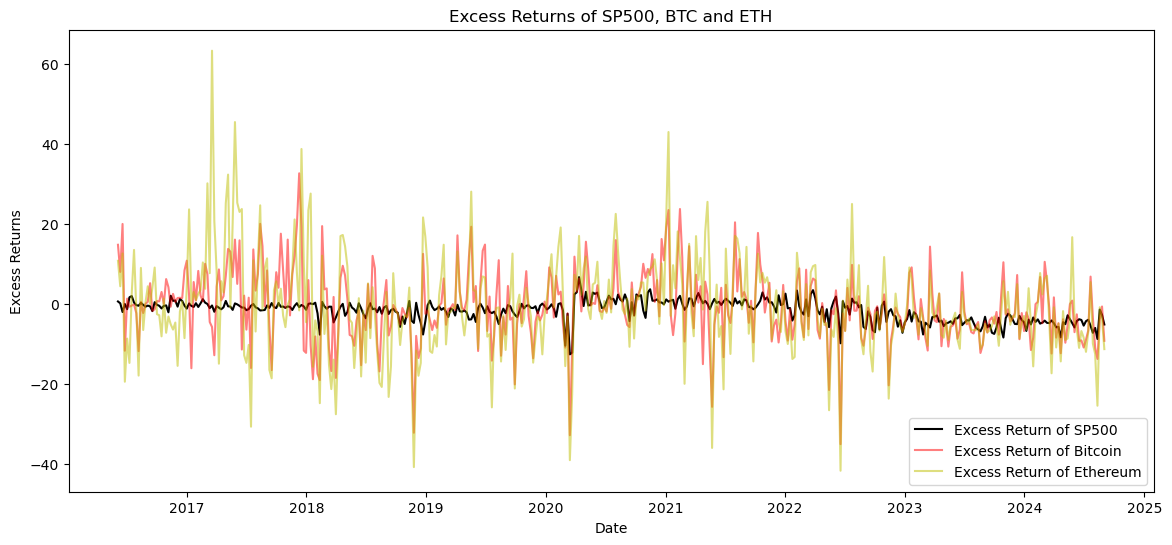

In [26]:
#Excess Returns
matplotlib.rcParams['figure.figsize']=[14,6]

plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.plot(master_df['ex_ret_SP500'],'k-',label='Excess Return of SP500')
plt.plot(master_df['ex_ret_BTCUSD'],'r-', alpha = 0.5, label='Excess Return of Bitcoin')
plt.plot(master_df['ex_ret_ETHUSD'],'y-', alpha = 0.5, label='Excess Return of Ethereum')
plt.title("Excess Returns of SP500, BTC and ETH")
# Set the legend
plt.legend(loc='lower right')

# Save the figure
plt.savefig('Excess returns.jpg',bbox_inches='tight')

# Display the figure
plt.show()

In [27]:
def plot_residuals(df,reg : list, plot_type,crypto:list = ["BTCUSD","ETHUSD"]):
    
    # Set up 2 subplots
    fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (12,4))
    
    
    col = 0
    for coin in crypto: 
        
        df["resid_"+coin] = reg[col].resid
        if plot_type == "scatter":
            ax[col].scatter(df["ex_ret_SP500"],reg[col].predict(), alpha = 0.2,c= "blue", label= "Predicted" )
            ax[col].scatter(df["ex_ret_SP500"], df["ex_ret_"+ coin], alpha= 0.5,marker = ".", c = "red", label = "Observed")

            ax[col].legend()
            ax[col].set_title("Predicted vs Observed Values")
            ax[col].set_xlabel("ex_ret_SP500")
            ax[col].set_ylabel("ex_ret_"+coin)
            
        elif plot_type == "hist":
            
            ax[col].hist(df["resid_"+coin], bins=50,color = "gray",edgecolor = "black",alpha = 1, density = True, zorder = 1)

            mu = df["resid_"+coin].mean()
            std = df["resid_"+coin].std()
            x = np.linspace(df["resid_"+coin].min(), df["resid_"+coin].max(), 100)
            dens_fct = sts.norm.pdf(x, mu, std)
            ax[ col].plot(x, dens_fct, color='black', alpha =0.7, label='Normal Distribution', zorder=2)

            ax[ col].set_title(f'Histogram of Residuals for {coin}')
            ax[ col].set_xlabel('Residuals')
            ax[ col].set_ylabel('Density') 
            ax[ col].legend()
        
        # Indexing to change col value from 0 to 1 
        col = col +1
        
    plt.tight_layout()
    
    plt.savefig('Residuals.jpg',bbox_inches='tight')
    plt.show()
    


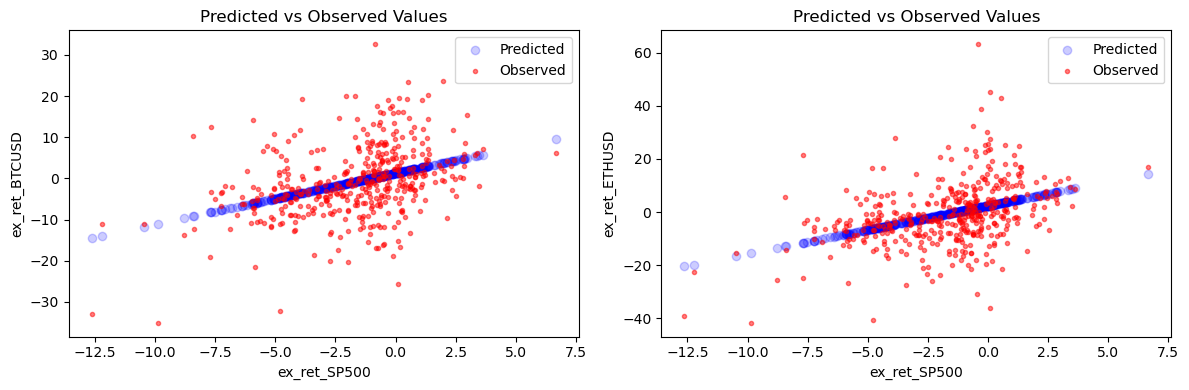

In [28]:
# Non - Robust Regression
plot_residuals(master_df, plot_type = "scatter",reg = [btc_regress,eth_regress])

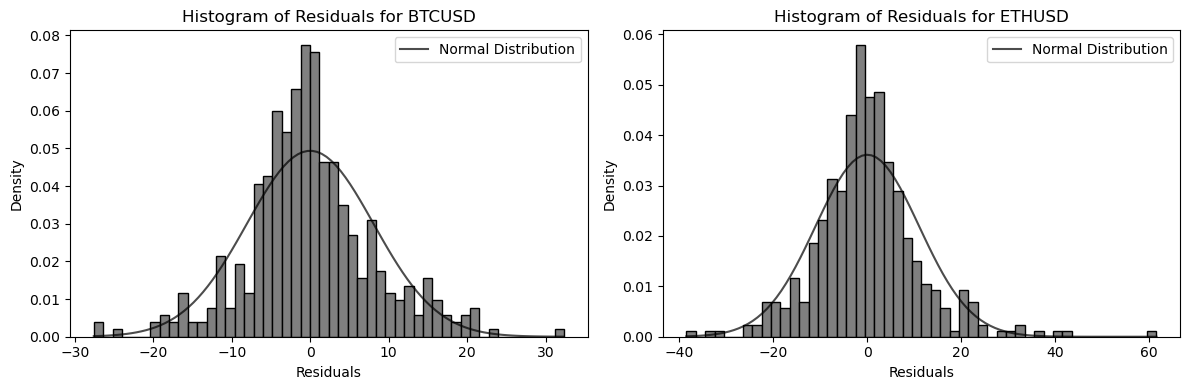

In [29]:
plot_residuals(master_df, plot_type = "hist",reg = [btc_regress,eth_regress])

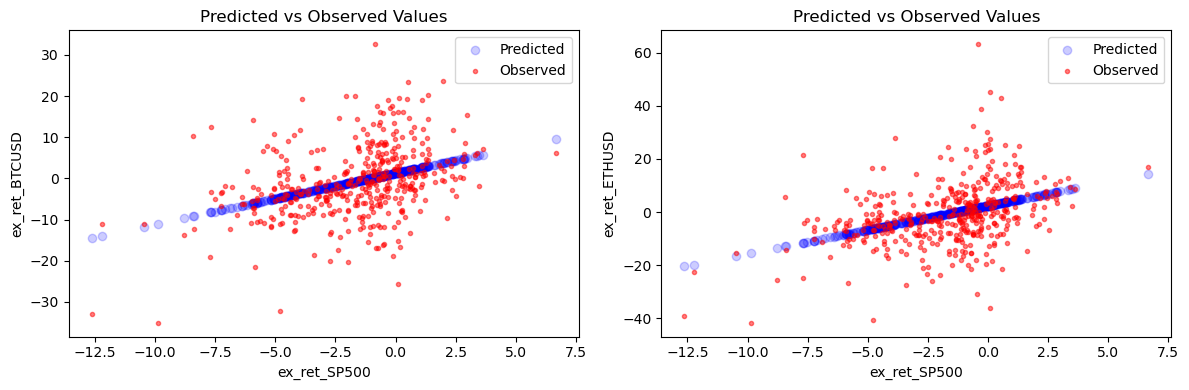

In [30]:
# Robust Regression 
plot_residuals(master_df, plot_type = "scatter",reg = [robust_BTC_result,robust_ETH_result])

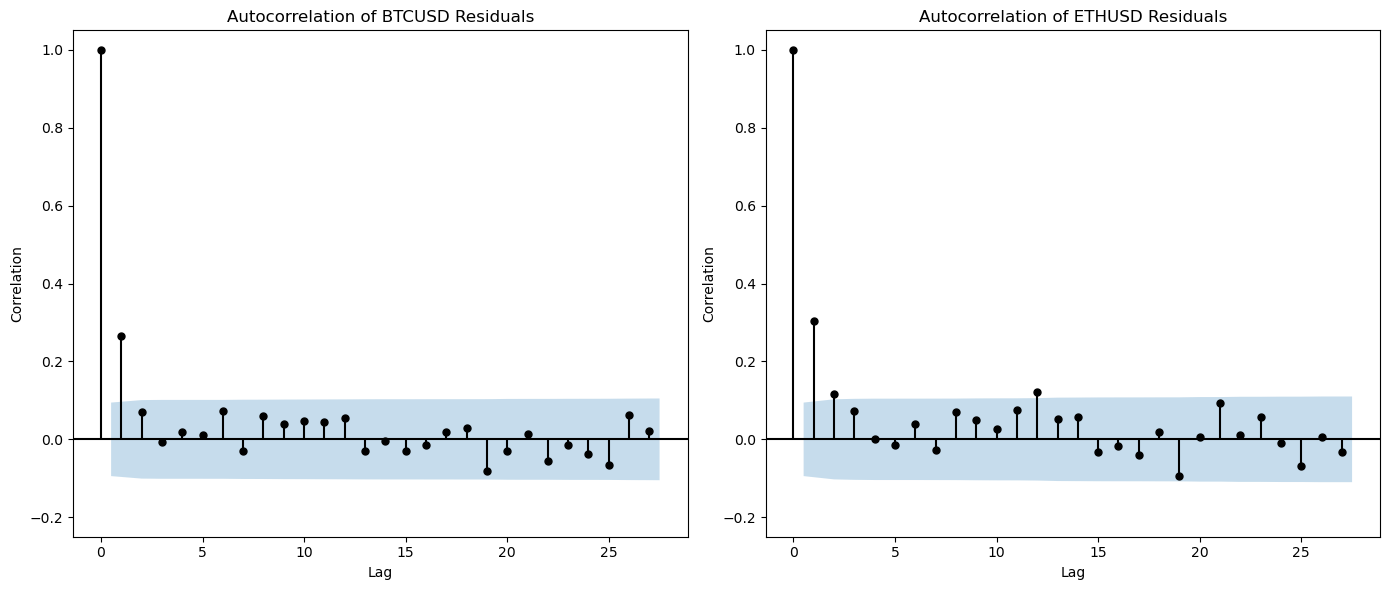

In [31]:
def ac_plot(crypto_1, crypto_2, reg_1,reg_2,colour):
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    resid_1 = reg_1.resid
    smp.graphics.tsa.plot_acf(resid_1, 
                                  vlines_kwargs={'colors': colour}, 
                                  ax=ax1, 
                              color=colour)
    ax1.set_ylim((-0.25, 1.05))
    ax1.set_title(f'Autocorrelation of {crypto_1} Residuals')
    ax1.set_ylabel('Correlation')
    ax1.set_xlabel('Lag')
    
    resid_2 = reg_2.resid
     
    smp.graphics.tsa.plot_acf(resid_2, 
                              vlines_kwargs={'colors': colour}, 
                                  ax=ax2, 
                              color=colour)
    ax2.set_ylim((-0.25, 1.05))
    ax2.set_title(f'Autocorrelation of {crypto_2} Residuals')
    ax2.set_ylabel('Correlation')
    ax2.set_xlabel('Lag')
    


    plt.tight_layout()
    
    plt.savefig('Autocorrelation.jpg',bbox_inches='tight')
    plt.show()
    
ac_plot("BTCUSD","ETHUSD", btc_regress, eth_regress, "black")

In [32]:
def scatter(reg, x_vals,title,df = master_df):
    
    matplotlib.rcParams['figure.figsize']=[10,6]
    # Linearity between dependent & independent variable
    plt.scatter(df[x_vals], reg.resid,marker=".", c = "black",alpha=0.5)
    # Save the figure
    plt.savefig(f'{title}.jpg',bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_vals)
    plt.ylabel("Residuals")


In [33]:
def scatter(reg1, reg2, x_vals, title1, title2, df = master_df):
   
    # Create the subplots, 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  

    # First scatter plot (left subplot)
    ax1.scatter(df[x_vals], reg1.resid, marker=".", c="black", alpha=0.5)
    ax1.set_title(title1)
    ax1.set_xlabel(x_vals)
    ax1.set_ylabel("Residuals")

    # Second scatter plot (right subplot)
    ax2.scatter(df[x_vals], reg2.resid, marker=".", c="black", alpha=0.5)
    ax2.set_title(title2)
    ax2.set_xlabel(x_vals)

    # Save the figure
    plt.savefig(f'{title1}_{title2}.jpg', bbox_inches='tight')

    # Show the plot
    plt.tight_layout()
    plt.show()

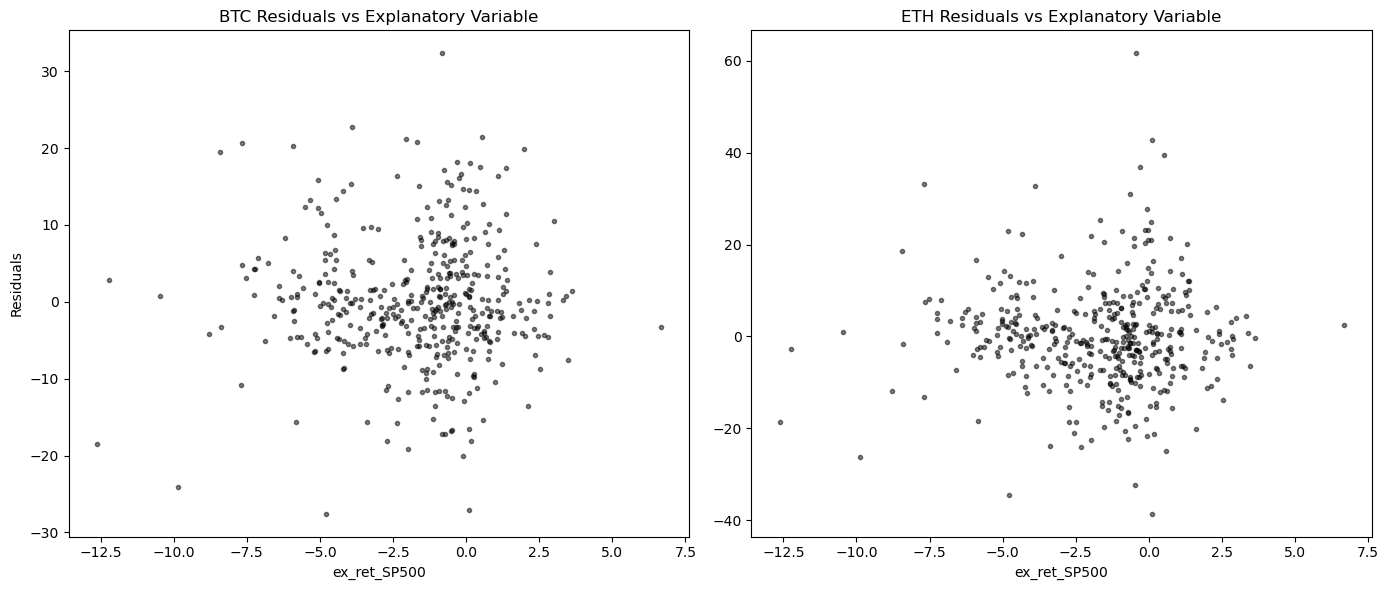

In [34]:
scatter(btc_regress,eth_regress, "ex_ret_SP500", "BTC Residuals vs Explanatory Variable",
        "ETH Residuals vs Explanatory Variable")

C:\Users\rorym\AppData\Local\Temp\ipykernel_22740\3118363465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["resid_"+coin] = reg[col].resid
C:\Users\rorym\AppData\Local\Temp\ipykernel_22740\3118363465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["resid_"+coin] = reg[col].resid


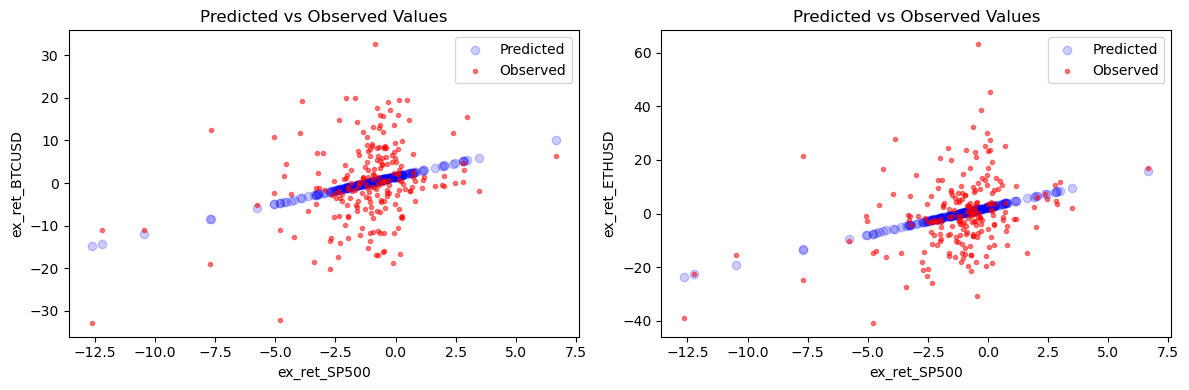

In [35]:
# Subset 1 plotting
plot_residuals(subset_1, plot_type = "scatter",reg = [subset_1_BTC,subset_1_ETH])

C:\Users\rorym\AppData\Local\Temp\ipykernel_22740\3118363465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["resid_"+coin] = reg[col].resid
C:\Users\rorym\AppData\Local\Temp\ipykernel_22740\3118363465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["resid_"+coin] = reg[col].resid


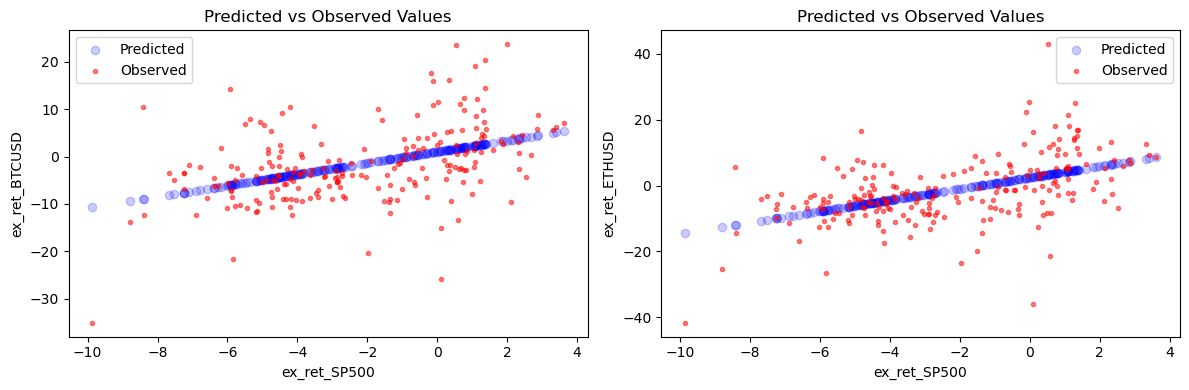

In [36]:
#Subset 2 plotting
plot_residuals(subset_2, plot_type = "scatter",reg = [subset_2_BTC,subset_2_ETH])

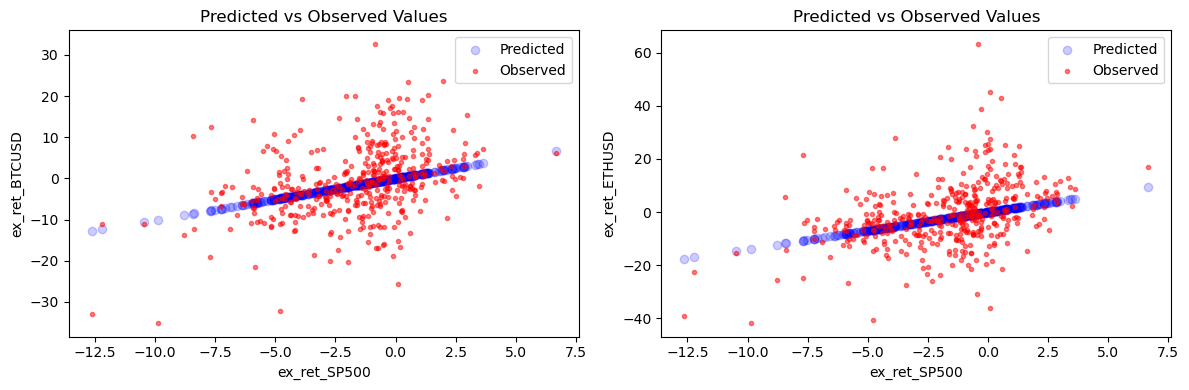

In [37]:
# No Constant 
plot_residuals(master_df, plot_type = "scatter",reg = [btc_regress_no_const,eth_regress_no_const])

<h1> Regression Summary Tables </h1>

In [38]:
def get_regression_summary(model):
    summary = model.summary()
    table1 = summary.tables[0]
    table2 = summary.tables[1]
    table3 = summary.tables[2]
    return {
        "Intercept": table2.data[1][1],
        "SE (intercept)":table2.data[1][2],
        "SP500 Coefficient": table2.data[2][1], 
        "SE (SP500)":table2.data[2][2],
        "p-value (SP500)": table2.data[2][4], 
        "R-squared": table1.data[0][3], 
        "Adjusted R-squared":table1.data[1][3], 
        "F-statistic": table1.data[2][3], 
        "Prob (F-statistic)": table1.data[3][3], 
        "AIC": table1.data[5][3], 
        "BIC": table1.data[6][3], 
        "Jarque-Bera" : table3.data[1][3],
        "Prob (JB)" : table3.data[2][3],
        "Durbin-Watson": table3.data[0][3], 
        "Skewness": table3.data[2][1],     
        "Kurtosis": table3.data[3][1], 
    }

def get_no_const_regression_summary(model):
    summary = model.summary()
    table1 = summary.tables[0]
    table2 = summary.tables[1]
    table3 = summary.tables[2]
    return {
        "SP500 Coefficient": table2.data[1][1], 
        "SE (SP500)":table2.data[1][2],
        "p-value (SP500)": table2.data[1][4], 
        "R-squared": table1.data[0][3], 
        "Adjusted R-squared":table1.data[1][3], 
        "F-statistic": table1.data[2][3], 
        "Prob (F-statistic)": table1.data[3][3], 
        "AIC": table1.data[5][3], 
        "BIC": table1.data[6][3], 
        "Jarque-Bera" : table3.data[1][3],
        "Prob (JB)" : table3.data[2][3],
        "Durbin-Watson": table3.data[0][3], 
        "Skewness": table3.data[2][1],      
        "Kurtosis": table3.data[3][1], 
    }

In [39]:
# Summary Table for Non-Robust regression 
summary_eth = get_regression_summary(btc_regress)
summary_btc = get_regression_summary(eth_regress)

# Combine summaries into a DataFrame
summary_df = pd.DataFrame([summary_eth, summary_btc])
summary_df = summary_df.transpose()

summary_df.reset_index(inplace=True)
summary_df.columns = ['Model', 'BTC','ETH']

# Set model as the index
summary_df.set_index('Model', inplace=True)

# Create Table
table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid',stralign='center', numalign='center')
print(table)

╒════════════════════╤══════════╤══════════╕
│       Model        │   BTC    │   ETH    │
╞════════════════════╪══════════╪══════════╡
│     Intercept      │  1.3006  │  2.3827  │
├────────────────────┼──────────┼──────────┤
│   SE (intercept)   │  0.465   │  0.636   │
├────────────────────┼──────────┼──────────┤
│ SP500 Coefficient  │  1.2409  │  1.8107  │
├────────────────────┼──────────┼──────────┤
│     SE (SP500)     │  0.149   │  0.204   │
├────────────────────┼──────────┼──────────┤
│  p-value (SP500)   │    0     │    0     │
├────────────────────┼──────────┼──────────┤
│     R-squared      │  0.139   │  0.155   │
├────────────────────┼──────────┼──────────┤
│ Adjusted R-squared │  0.137   │  0.153   │
├────────────────────┼──────────┼──────────┤
│    F-statistic     │  69.24   │  78.95   │
├────────────────────┼──────────┼──────────┤
│ Prob (F-statistic) │ 1.17e-15 │ 1.77e-17 │
├────────────────────┼──────────┼──────────┤
│        AIC         │   3027   │   3297   │
├─────────

In [40]:
# Summary Table for Robust regression 
summary_eth = get_regression_summary(robust_BTC_result)
summary_btc = get_regression_summary(robust_ETH_result)

# Combine summaries into a DataFrame
summary_df = pd.DataFrame([summary_eth, summary_btc])
summary_df = summary_df.transpose()
# Set the "Model" as the index
summary_df.reset_index(inplace=True)

# Rename the columns for clarity
summary_df.columns = ['Robust Model', 'BTC','ETH']

# Now set 'Model' as the index
summary_df.set_index('Robust Model', inplace=True)

# Create a formal table using 'tabulate'
table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid',stralign='center', numalign='center')

# Print the formatted table
print(table)


╒════════════════════╤══════════╤══════════╕
│    Robust Model    │   BTC    │   ETH    │
╞════════════════════╪══════════╪══════════╡
│     Intercept      │  1.3006  │  2.3827  │
├────────────────────┼──────────┼──────────┤
│   SE (intercept)   │  0.621   │  0.939   │
├────────────────────┼──────────┼──────────┤
│ SP500 Coefficient  │  1.2409  │  1.8107  │
├────────────────────┼──────────┼──────────┤
│     SE (SP500)     │   0.18   │  0.246   │
├────────────────────┼──────────┼──────────┤
│  p-value (SP500)   │    0     │    0     │
├────────────────────┼──────────┼──────────┤
│     R-squared      │  0.139   │  0.155   │
├────────────────────┼──────────┼──────────┤
│ Adjusted R-squared │  0.137   │  0.153   │
├────────────────────┼──────────┼──────────┤
│    F-statistic     │  47.48   │  54.01   │
├────────────────────┼──────────┼──────────┤
│ Prob (F-statistic) │ 1.99e-11 │ 1.02e-12 │
├────────────────────┼──────────┼──────────┤
│        AIC         │   3027   │   3297   │
├─────────

In [41]:
#BTC Subset Regression Table
summary_btc_sample_1 = get_regression_summary(subset_1_BTC)
summary_btc_sample_2 = get_regression_summary(subset_2_BTC)

# Combine summaries into a DataFrame
summary_df = pd.DataFrame([summary_btc_sample_1, summary_btc_sample_2])
summary_df = summary_df.transpose()

summary_df.reset_index(inplace=True)
summary_df.columns = ["BTC","Subset 1","Subset 2"]

# Set model as the index
summary_df.set_index('BTC', inplace=True)

# Create Table
table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid',stralign='center', numalign='center')
print(table)

╒════════════════════╤════════════╤════════════╕
│        BTC         │  Subset 1  │  Subset 2  │
╞════════════════════╪════════════╪════════════╡
│     Intercept      │   1.5032   │   1.0197   │
├────────────────────┼────────────┼────────────┤
│   SE (intercept)   │   0.693    │   0.613    │
├────────────────────┼────────────┼────────────┤
│ SP500 Coefficient  │   1.2884   │   1.1898   │
├────────────────────┼────────────┼────────────┤
│     SE (SP500)     │   0.287    │   0.166    │
├────────────────────┼────────────┼────────────┤
│  p-value (SP500)   │     0      │     0      │
├────────────────────┼────────────┼────────────┤
│     R-squared      │   0.086    │   0.193    │
├────────────────────┼────────────┼────────────┤
│ Adjusted R-squared │   0.082    │    0.19    │
├────────────────────┼────────────┼────────────┤
│    F-statistic     │   20.14    │   51.28    │
├────────────────────┼────────────┼────────────┤
│ Prob (F-statistic) │  1.17e-05  │  1.27e-11  │
├───────────────────

In [42]:
#ETH Subset Regression Table
summary_eth_sample_1 = get_regression_summary(subset_1_ETH)
summary_eth_sample_2 = get_regression_summary(subset_2_ETH)

# Combine summaries into a DataFrame
summary_df = pd.DataFrame([summary_eth_sample_1, summary_eth_sample_2])
summary_df = summary_df.transpose()

summary_df.reset_index(inplace=True)

summary_df.columns = ["ETH",'Subset 1','Subset 2']

# Set model as the index
summary_df.set_index('ETH', inplace=True)

# Create Table
table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid',stralign='center', numalign='center')
print(table)

╒════════════════════╤════════════╤════════════╕
│        ETH         │  Subset 1  │  Subset 2  │
╞════════════════════╪════════════╪════════════╡
│     Intercept      │   2.3746   │   2.4083   │
├────────────────────┼────────────┼────────────┤
│   SE (intercept)   │   1.001    │   0.753    │
├────────────────────┼────────────┼────────────┤
│ SP500 Coefficient  │   2.0547   │   1.7073   │
├────────────────────┼────────────┼────────────┤
│     SE (SP500)     │   0.415    │   0.204    │
├────────────────────┼────────────┼────────────┤
│  p-value (SP500)   │     0      │     0      │
├────────────────────┼────────────┼────────────┤
│     R-squared      │   0.103    │   0.246    │
├────────────────────┼────────────┼────────────┤
│ Adjusted R-squared │   0.099    │   0.243    │
├────────────────────┼────────────┼────────────┤
│    F-statistic     │   24.51    │   69.88    │
├────────────────────┼────────────┼────────────┤
│ Prob (F-statistic) │  1.5e-06   │   8e-15    │
├───────────────────

In [43]:
# Summary Table for No constant 
summary_btc = get_no_const_regression_summary(btc_regress_no_const)
summary_eth = get_no_const_regression_summary(eth_regress_no_const)

# Combine summaries into a DataFrame
summary_df = pd.DataFrame([summary_btc, summary_eth])
summary_df = summary_df.transpose()

summary_df.reset_index(inplace=True)
summary_df.columns = ["Model",'BTC','ETH']

# Set model as the index
summary_df.set_index("Model", inplace=True)

# Create Table
table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid',stralign='center', numalign='center')
print(table)

╒════════════════════╤══════════╤══════════╕
│       Model        │   BTC    │   ETH    │
╞════════════════════╪══════════╪══════════╡
│ SP500 Coefficient  │  1.0133  │  1.3937  │
├────────────────────┼──────────┼──────────┤
│     SE (SP500)     │  0.126   │  0.173   │
├────────────────────┼──────────┼──────────┤
│  p-value (SP500)   │    0     │    0     │
├────────────────────┼──────────┼──────────┤
│     R-squared      │  0.131   │  0.131   │
├────────────────────┼──────────┼──────────┤
│ Adjusted R-squared │  0.129   │  0.129   │
├────────────────────┼──────────┼──────────┤
│    F-statistic     │  64.73   │  64.66   │
├────────────────────┼──────────┼──────────┤
│ Prob (F-statistic) │ 8.44e-15 │ 8.72e-15 │
├────────────────────┼──────────┼──────────┤
│        AIC         │   3033   │   3308   │
├────────────────────┼──────────┼──────────┤
│        BIC         │   3037   │   3312   │
├────────────────────┼──────────┼──────────┤
│    Jarque-Bera     │  32.868  │ 259.329  │
├─────────